In [38]:
from google.colab import drive
drive.mount("/content/drive")

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [76]:
import numpy as np
import pandas as pd
from sklearn.metrics.pairwise import cosine_similarity
import matplotlib.pyplot as plt
from scipy.cluster.hierarchy import dendrogram, linkage
import seaborn as sns

In [40]:
df = pd.read_csv("/content/drive/MyDrive/Capstone/Capstone2025_nsi_lvl9_with_landcover_and_color.csv.gz")
df.head()

,h3,fips,st_damcat,bldgtype,lc_type,loc,clr,clr_cc
0,8929a960d6fffff,6047,RES,M,urban+crop,POINT(-120.828147398273 37.0724076637771),orange,8
1,8929a978c07ffff,6047,RES,M,urban+crop,POINT(-120.63428156983 36.9838900827867),orange,8
2,892836da147ffff,6047,RES,M,urban+crop,POINT(-120.464731172229 37.3234892623252),orange,11
3,892836c644fffff,6047,RES,M,urban+crop,POINT(-120.787252301526 37.4298893882365),orange,12
4,892836d736fffff,6047,RES,M,urban+crop,POINT(-120.716239893409 37.3391233398179),orange,1


In [41]:
df.columns

Index(['h3', 'fips', 'st_damcat', 'bldgtype', 'lc_type', 'loc', 'clr',
       'clr_cc'],
      dtype='object')

## Most popular color by county

In [42]:
(
    df.groupby(['fips', 'clr'])
    [['clr_cc']]
    .sum()
    .reset_index()
    .groupby(['fips'])
    # get most popular color
    .apply(lambda x: x.nlargest(1, 'clr_cc'))
    .reset_index(drop=True)
)

/tmp/ipython-input-3320713167.py:8: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  .apply(lambda x: x.nlargest(1, 'clr_cc'))


,fips,clr,clr_cc
0,6001,cocoa,112563
1,6003,tan,206
2,6005,coffee,4281
3,6007,brown,19015
4,6009,cocoa,5546
5,6011,beige,1732
6,6013,brown,102336
7,6015,coffee,2844
8,6017,brown,26831
9,6019,cocoa,59738


In [43]:
cnt_total_structures = df.groupby('fips')['clr_cc'].sum().reset_index()
cnt_total_structures.rename(columns={'clr_cc': 'total_structures_in_county'}, inplace=True)
cnt_total_structures.head()

,fips,total_structures_in_county
0,6001,393303
1,6003,467
2,6005,10277
3,6007,53258
4,6009,16216


In [44]:
popular_color_by_county = (
    df.groupby(['fips', 'clr'])
    [['clr_cc']]
    .sum()
    .reset_index()
    .groupby(['fips'])
    .apply(lambda x: x.nlargest(1, 'clr_cc'))
    .reset_index(drop=True)
)

popular_color_by_county = pd.merge(popular_color_by_county, cnt_total_structures, on='fips')
popular_color_by_county['proportion'] = popular_color_by_county['clr_cc'] / popular_color_by_county['total_structures_in_county']
popular_color_by_county.head()

/tmp/ipython-input-913303443.py:7: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  .apply(lambda x: x.nlargest(1, 'clr_cc'))


,fips,clr,clr_cc,total_structures_in_county,proportion
0,6001,cocoa,112563,393303,0.286199
1,6003,tan,206,467,0.441113
2,6005,coffee,4281,10277,0.416561
3,6007,brown,19015,53258,0.357036
4,6009,cocoa,5546,16216,0.342008


In [45]:
cnt_total_structures_lc = df.groupby('lc_type')['clr_cc'].sum().reset_index()
cnt_total_structures_lc.rename(columns={'clr_cc': 'total_structures_in_lc'}, inplace=True)
cnt_total_structures_lc

,lc_type,total_structures_in_lc
0,barren,23711
1,crop,33257
2,forest,485853
3,grass,15954
4,other,4
5,shrub,134092
6,urban,5671471
7,urban+barren,283037
8,urban+crop,562410
9,urban+forest,1188645


Here there are most popular colors by county with their proportions in the county.

In [46]:
popular_color_by_landcover = (
    df.groupby(['lc_type', 'clr'])
    [['clr_cc']]
    .sum()
    .reset_index()
    .groupby(['lc_type'])
    .apply(lambda x: x.nlargest(1, 'clr_cc'))
    .reset_index(drop=True)
)

popular_color_by_landcover = pd.merge(popular_color_by_landcover, cnt_total_structures_lc, on='lc_type')
popular_color_by_landcover['proportion'] = popular_color_by_landcover['clr_cc'] / popular_color_by_landcover['total_structures_in_lc']
popular_color_by_landcover

/tmp/ipython-input-1195917122.py:7: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  .apply(lambda x: x.nlargest(1, 'clr_cc'))


,lc_type,clr,clr_cc,total_structures_in_lc,proportion
0,barren,cocoa,9809,23711,0.413690
1,crop,alabaster,7518,33257,0.226058
2,forest,brown,98452,485853,0.202637
3,grass,alabaster,3835,15954,0.240379
4,other,brown,4,4,1.000000
5,shrub,cocoa,34210,134092,0.255123
6,urban,cocoa,1412584,5671471,0.249068
7,urban+barren,cocoa,67706,283037,0.239213
8,urban+crop,brown,81618,562410,0.145122
9,urban+forest,brown,212844,1188645,0.179064


## Looking for similar colors

The goal here is to see what colors are "similar", e.g. what colors are used in similar contexts and could potentially be grouped.

In [47]:
# for each color, what is its distribution across building types? (then: same for damcat and landcover)

clr_bldgtype_distributions = pd.crosstab(df['clr'], df['bldgtype'], normalize='index')
clr_bldgtype_distributions = clr_bldgtype_distributions.add_prefix('bldgtype_')
clr_bldgtype_distributions.reset_index(inplace=True)
clr_bldgtype_distributions.head()

bldgtype,clr,bldgtype_C,bldgtype_H,bldgtype_M,bldgtype_S,bldgtype_W
0,alabaster,0.006012,0.051735,0.454108,0.006673,0.481472
1,amber,0.031621,0.036664,0.447308,0.012660,0.471748
2,aqua,0.001125,0.079115,0.439258,0.003562,0.476940
3,aquamarine,0.001077,0.064641,0.447317,0.003017,0.483947
4,auburn,0.452345,0.004755,0.251135,0.103307,0.188459


In [48]:
clr_damcat_distributions = pd.crosstab(df['clr'], df['st_damcat'], normalize='index')
clr_damcat_distributions = clr_damcat_distributions.add_prefix('damcat_')
clr_damcat_distributions.reset_index(inplace=True)
clr_damcat_distributions.head()

st_damcat,clr,damcat_COM,damcat_IND,damcat_PUB,damcat_RES
0,alabaster,0.000000,0.000000,0.00000,1.000000
1,amber,0.048828,0.006861,0.00288,0.941431
2,aqua,0.000000,0.000000,0.00000,1.000000
3,aquamarine,0.000000,0.000000,0.00000,1.000000
4,auburn,0.864059,0.122542,0.01340,0.000000


In [49]:
clr_lc_distributions = pd.crosstab(df['clr'], df['lc_type'], normalize='index')
clr_lc_distributions = clr_lc_distributions.add_prefix('lc_')
clr_lc_distributions.reset_index(inplace=True)
clr_lc_distributions.head()

lc_type,clr,lc_barren,lc_crop,lc_forest,lc_grass,lc_other,lc_shrub,lc_urban,lc_urban+barren,lc_urban+crop,lc_urban+forest,lc_urban+grass,lc_urban+other,lc_urban+shrub
0,alabaster,0.008371,0.024424,0.121550,0.010713,0.0,0.049816,0.362180,0.049689,0.062343,0.134494,0.133426,0.000058,0.042937
1,amber,0.005265,0.001603,0.029132,0.002359,0.0,0.017091,0.492396,0.063912,0.060159,0.123303,0.154102,0.000085,0.050594
2,aqua,0.008249,0.013498,0.242407,0.005624,0.0,0.110049,0.041057,0.022685,0.171166,0.145107,0.197975,0.000375,0.041807
3,aquamarine,0.032105,0.059039,0.235294,0.003232,0.0,0.060116,0.017238,0.021763,0.419522,0.063348,0.073691,0.000000,0.014652
4,auburn,0.000432,0.000864,0.000216,0.000000,0.0,0.000000,0.928247,0.001513,0.031986,0.016641,0.012319,0.000000,0.007780


In [50]:
# join the 3 distribution tables

distributions = clr_bldgtype_distributions.merge(clr_damcat_distributions, on='clr').merge(clr_lc_distributions, on='clr')
distributions.head()

,clr,bldgtype_C,bldgtype_H,bldgtype_M,bldgtype_S,bldgtype_W,damcat_COM,damcat_IND,damcat_PUB,damcat_RES,...,lc_grass,lc_other,lc_shrub,lc_urban,lc_urban+barren,lc_urban+crop,lc_urban+forest,lc_urban+grass,lc_urban+other,lc_urban+shrub
0,alabaster,0.006012,0.051735,0.454108,0.006673,0.481472,0.000000,0.000000,0.00000,1.000000,...,0.010713,0.0,0.049816,0.362180,0.049689,0.062343,0.134494,0.133426,0.000058,0.042937
1,amber,0.031621,0.036664,0.447308,0.012660,0.471748,0.048828,0.006861,0.00288,0.941431,...,0.002359,0.0,0.017091,0.492396,0.063912,0.060159,0.123303,0.154102,0.000085,0.050594
2,aqua,0.001125,0.079115,0.439258,0.003562,0.476940,0.000000,0.000000,0.00000,1.000000,...,0.005624,0.0,0.110049,0.041057,0.022685,0.171166,0.145107,0.197975,0.000375,0.041807
3,aquamarine,0.001077,0.064641,0.447317,0.003017,0.483947,0.000000,0.000000,0.00000,1.000000,...,0.003232,0.0,0.060116,0.017238,0.021763,0.419522,0.063348,0.073691,0.000000,0.014652
4,auburn,0.452345,0.004755,0.251135,0.103307,0.188459,0.864059,0.122542,0.01340,0.000000,...,0.000000,0.0,0.000000,0.928247,0.001513,0.031986,0.016641,0.012319,0.000000,0.007780


In [51]:
distributions = distributions.set_index('clr')

In [52]:
# get the cosine similarity for the colors (treat each row as a vector) -> then build a similarity matrix

similarity_matrix = cosine_similarity(distributions)
similarity_matrix

array([[1.        , 0.98926122, 0.95687241, ..., 0.99486489, 0.88385652,
        0.88541859],
       [0.98926122, 1.        , 0.91143418, ..., 0.99417792, 0.82056456,
        0.8608641 ],
       [0.95687241, 0.91143418, 1.        , ..., 0.93512436, 0.9427301 ,
        0.93103042],
       ...,
       [0.99486489, 0.99417792, 0.93512436, ..., 1.        , 0.86343485,
        0.87081668],
       [0.88385652, 0.82056456, 0.9427301 , ..., 0.86343485, 1.        ,
        0.79345221],
       [0.88541859, 0.8608641 , 0.93103042, ..., 0.87081668, 0.79345221,
        1.        ]])

In [53]:
similarity_df = pd.DataFrame(similarity_matrix, index=distributions.index, columns=distributions.index)
similarity_df

clr,alabaster,amber,aqua,aquamarine,auburn,azure,bar,beige,blue,brown,...,plum,purple,red,sage,scarlet,sienna,tan,terracotta,verde,yellow
clr,,,,,,,,,,,,,,,,,,,,,
alabaster,1.000000,0.989261,0.956872,0.918290,0.309537,0.976945,0.266607,0.408283,0.989425,0.957147,...,0.299243,0.978752,0.985639,0.975008,0.962896,0.600740,0.685483,0.994865,0.883857,0.885419
amber,0.989261,1.000000,0.911434,0.871518,0.409939,0.993669,0.315434,0.499256,0.996023,0.921559,...,0.369258,0.996570,0.999183,0.958093,0.983613,0.677811,0.656449,0.994178,0.820565,0.860864
aqua,0.956872,0.911434,1.000000,0.972792,0.142507,0.883190,0.240948,0.252971,0.911469,0.981548,...,0.228685,0.882812,0.904164,0.963209,0.860128,0.471570,0.750675,0.935124,0.942730,0.931030
aquamarine,0.918290,0.871518,0.972792,1.000000,0.130598,0.850268,0.226598,0.234345,0.875818,0.941435,...,0.224909,0.848059,0.867435,0.923885,0.846146,0.461282,0.699348,0.893373,0.902478,0.962967
auburn,0.309537,0.409939,0.142507,0.130598,1.000000,0.439455,0.805212,0.985989,0.403538,0.276632,...,0.896553,0.443035,0.430664,0.381322,0.444673,0.934143,0.486943,0.360394,0.137541,0.151941
azure,0.976945,0.993669,0.883190,0.850268,0.439455,1.000000,0.291429,0.522987,0.996068,0.892478,...,0.360451,0.996743,0.994924,0.938605,0.992285,0.692394,0.622497,0.983886,0.785514,0.839156
bar,0.266607,0.315434,0.240948,0.226598,0.805212,0.291429,1.000000,0.821008,0.294324,0.383354,...,0.976735,0.303647,0.323358,0.422135,0.282293,0.812444,0.711167,0.306259,0.282432,0.244256
beige,0.408283,0.499256,0.252971,0.234345,0.985989,0.522987,0.821008,1.000000,0.493377,0.385365,...,0.905802,0.527119,0.518191,0.482457,0.524181,0.964457,0.574552,0.455283,0.248221,0.245892
blue,0.989425,0.996023,0.911469,0.875818,0.403538,0.996068,0.294324,0.493377,1.000000,0.923243,...,0.350828,0.994229,0.994712,0.959617,0.987670,0.668333,0.655864,0.994191,0.833058,0.850898


In [65]:
similarity_df.to_csv('color_similarity_matrix.csv')

Below is an attempt at visualizing "similar" colors.

Surprisingly, colors such as "grey" and "gray" (that semantically mean the same thing) are pretty far away, while such colors as "coffee" and "verde" are close. That suggests those colors are used in similar contexts (e.g. same building types, same landcovers), so for the purposes of the dataset they are similar.

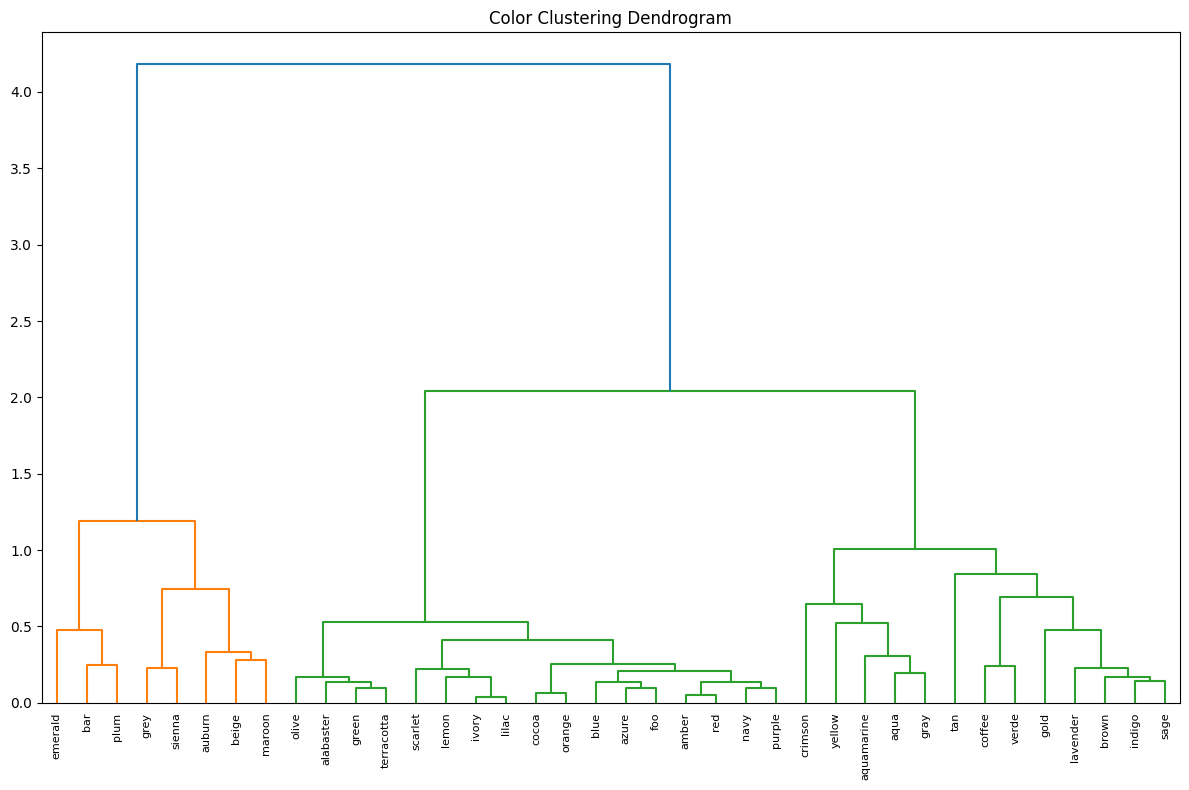

In [54]:
linkage_matrix = linkage(distributions, method='ward')
plt.figure(figsize=(12, 8))
dendrogram(linkage_matrix, labels=distributions.index, leaf_rotation=90)
plt.title('Color Clustering Dendrogram')
plt.tight_layout()
plt.show()

Below is some further exploration of the findings

In [56]:
similarity_df['verde']

,verde
clr,
alabaster,0.883857
amber,0.820565
aqua,0.942730
aquamarine,0.902478
auburn,0.137541
azure,0.785514
bar,0.282432
beige,0.248221
blue,0.833058


In [66]:
# how many times does each color appear + what are their categorical distributions?
print(df['clr'].value_counts()[['verde', 'coffee']])
print(distributions.loc[['verde', 'coffee']])

clr
verde     12742
coffee    40717
Name: count, dtype: int64
        bldgtype_C  bldgtype_H  bldgtype_M  bldgtype_S  bldgtype_W  \
clr                                                                  
verde     0.029273    0.158766    0.379689    0.016010    0.416261   
coffee    0.059705    0.096790    0.386571    0.041481    0.415453   

        damcat_COM  damcat_IND  damcat_PUB  damcat_RES  lc_barren  ...  \
clr                                                                ...   
verde     0.053367    0.005337    0.003375    0.937922   0.000000  ...   
coffee    0.119508    0.016209    0.004666    0.859616   0.000835  ...   

        lc_grass  lc_other  lc_shrub  lc_urban  lc_urban+barren  \
clr                                                               
verde   0.002119       0.0  0.039711  0.000000         0.000000   
coffee  0.003807       0.0  0.056586  0.096839         0.002358   

        lc_urban+crop  lc_urban+forest  lc_urban+grass  lc_urban+other  \
clr              

In [67]:
# how many times does each color appear + what are their categorical distributions?
print(df['clr'].value_counts()[['grey', 'gray']])
print(distributions.loc[['grey', 'gray']])

clr
grey    32094
gray    13665
Name: count, dtype: int64
      bldgtype_C  bldgtype_H  bldgtype_M  bldgtype_S  bldgtype_W  damcat_COM  \
clr                                                                            
grey    0.263819    0.033090    0.314856    0.082850    0.305384    0.509753   
gray    0.043396    0.045884    0.435638    0.015514    0.459568    0.077131   

      damcat_IND  damcat_PUB  damcat_RES  lc_barren  ...  lc_grass  lc_other  \
clr                                                  ...                       
grey    0.073846    0.031439    0.384963   0.001963  ...  0.006917       0.0   
gray    0.015368    0.004830    0.902671   0.010904  ...  0.008708       0.0   

      lc_shrub  lc_urban  lc_urban+barren  lc_urban+crop  lc_urban+forest  \
clr                                                                         
grey  0.022029   0.55110         0.020440       0.066835         0.084128   
gray  0.059495   0.05569         0.009367       0.230077         0.15

In [68]:
# how many times does each color appear + what are their categorical distributions?
print(df['clr'].value_counts()[['verde', 'green']])
print(distributions.loc[['verde', 'green']])

clr
verde     12742
green    119011
Name: count, dtype: int64
       bldgtype_C  bldgtype_H  bldgtype_M  bldgtype_S  bldgtype_W  damcat_COM  \
clr                                                                             
verde    0.029273    0.158766    0.379689    0.016010    0.416261    0.053367   
green    0.017410    0.036333    0.451429    0.008302    0.486526    0.029266   

       damcat_IND  damcat_PUB  damcat_RES  lc_barren  ...  lc_grass  lc_other  \
clr                                                   ...                       
verde    0.005337    0.003375    0.937922   0.000000  ...  0.002119       0.0   
green    0.003428    0.001622    0.965684   0.006571  ...  0.002554       0.0   

       lc_shrub  lc_urban  lc_urban+barren  lc_urban+crop  lc_urban+forest  \
clr                                                                          
verde  0.039711  0.000000         0.000000       0.049521         0.313216   
green  0.025384  0.454403         0.056281       0.040

## Conditional Distributions & Interaction Structure

In [80]:
# color distribution conditioned on landcover -- for each lc, what is the color distribution?

color_by_lc = pd.crosstab(df['lc_type'], df['clr'], normalize='index')
color_by_lc

clr,alabaster,amber,aqua,aquamarine,auburn,azure,bar,beige,blue,brown,...,plum,purple,red,sage,scarlet,sienna,tan,terracotta,verde,yellow
lc_type,,,,,,,,,,,,,,,,,,,,,
barren,0.108499,0.055380,0.003016,0.010212,0.000137,0.000822,0.000137,0.008293,0.001028,0.001165,...,0.000343,0.023235,0.081083,0.000891,0.000000,0.002125,0.000000,0.003975,0.000000,0.000548
crop,0.200582,0.010683,0.003127,0.011899,0.000174,0.021582,0.020410,0.008555,0.008555,0.130537,...,0.000521,0.017935,0.021061,0.038171,0.000217,0.004994,0.001390,0.021669,0.001390,0.000000
forest,0.098031,0.019067,0.005514,0.004657,0.000004,0.009826,0.001015,0.006150,0.012969,0.145982,...,0.000107,0.010316,0.014696,0.065846,0.000009,0.001586,0.004606,0.050318,0.029264,0.000000
grass,0.207923,0.037151,0.003079,0.001539,0.000000,0.020833,0.004413,0.009647,0.002053,0.046388,...,0.000821,0.016728,0.037356,0.018576,0.000000,0.001232,0.001847,0.030788,0.002771,0.000000
other,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
shrub,0.112697,0.031377,0.007022,0.003337,0.000000,0.029678,0.001675,0.015599,0.014199,0.097421,...,0.000347,0.009654,0.049548,0.039511,0.000024,0.005192,0.003553,0.043722,0.006053,0.000251
urban,0.060954,0.067252,0.000195,0.000071,0.003822,0.033219,0.000821,0.023389,0.015132,0.012564,...,0.000907,0.055678,0.068015,0.014781,0.001589,0.012597,0.000000,0.055830,0.000000,0.000213
urban+barren,0.103926,0.108483,0.001338,0.001117,0.000077,0.001139,0.000022,0.004380,0.002566,0.002356,...,0.000387,0.098971,0.126078,0.001770,0.000088,0.001858,0.000000,0.008693,0.000000,0.000564
urban+crop,0.079974,0.062629,0.006193,0.013207,0.001004,0.032159,0.003738,0.008499,0.014401,0.079486,...,0.002978,0.041588,0.071237,0.040930,0.003100,0.021204,0.000414,0.063640,0.004280,0.020153


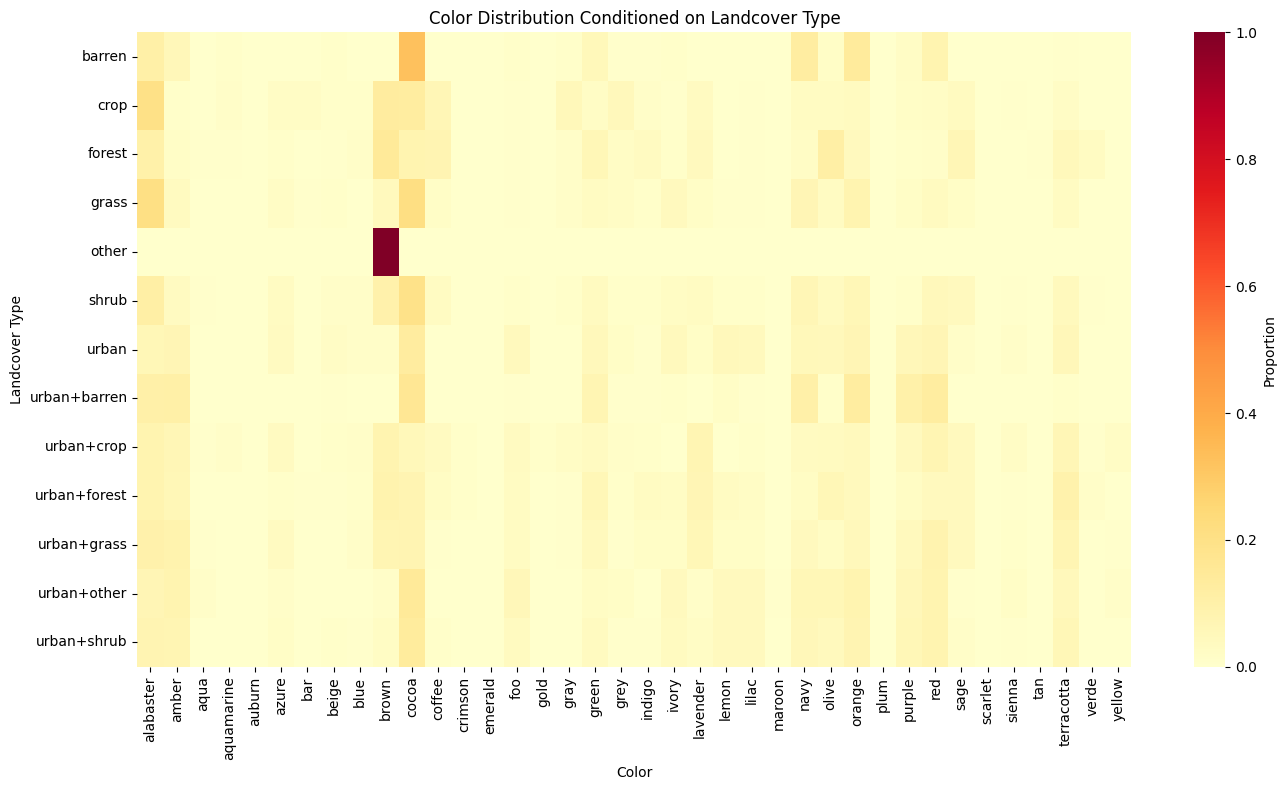

In [81]:
# heatmap of color distribution by landcover
plt.figure(figsize=(14, 8))
sns.heatmap(color_by_lc, cmap='YlOrRd', annot=False, cbar_kws={'label': 'Proportion'})
plt.title('Color Distribution Conditioned on Landcover Type')
plt.xlabel('Color')
plt.ylabel('Landcover Type')
plt.tight_layout()
plt.show()

The heatmap shows that color distributions vary by landcover. Some colors like alabaster, amber, brown, and cocoa are generally popular, there are clear landcover-specific patterns:
- "other" landcover is almost entirely brown (100% spike)
- barren has higher proportions for cocoa, navy, and orange
- some colors (e.g. navy and orange) show identical patterns across landcover types -- this is correlated this the previous findings of "similar" colors

Conclusion: landcover affects color variability

In [84]:
# does conditioning reduce or reveal variability? (do colors vary more overall or within landcovers?)

# how much do color proportions vary across all data?
overall_clr_props = df['clr'].value_counts(normalize=True)
overall_var = overall_clr_props.var()

# for each landcover, calculate color variance and then average
within_lc_vars = color_by_lc.var(axis=1)  # variance across colors for each landcover
avg_within_lc_var = within_lc_vars.mean()

print(f"overall variance: {overall_var}")
print(f"variance by landcover: {avg_within_lc_var}")

overall variance: 0.0007343675708120235
variance by landcover: 0.003419541415463012


Variance Analysis:
- Overall color variance: 0.0007
- Average within-landcover variance: 0.0034


Conditioning on landcover "reveals" variability. When we mix all landcovers together, color distribution appears somewhat even, but when we look at each landcover separately, we see that each has strong preferences for specific color/colors.

## What color-landcover combos are "stable" (common) and what combos are rare?

In [98]:
lc_clr_cnts = df.groupby(['lc_type', 'clr']).size().reset_index(name='count')
lc_clr_cnts.head()

,lc_type,clr,count
0,barren,alabaster,1583
1,barren,amber,808
2,barren,aqua,44
3,barren,aquamarine,149
4,barren,auburn,2


In [99]:
# get proportions (color distributions within landcovers)
lc_totals = df.groupby('lc_type').size().reset_index(name='total')
lc_clr_cnts = lc_clr_cnts.merge(lc_totals, on='lc_type')
lc_clr_cnts['proportion'] = lc_clr_cnts['count'] / lc_clr_cnts['total']
lc_clr_cnts.head(10)

,lc_type,clr,count,total,proportion
0,barren,alabaster,1583,14590,0.108499
1,barren,amber,808,14590,0.055380
2,barren,aqua,44,14590,0.003016
3,barren,aquamarine,149,14590,0.010212
4,barren,auburn,2,14590,0.000137
5,barren,azure,12,14590,0.000822
6,barren,bar,2,14590,0.000137
7,barren,beige,121,14590,0.008293
8,barren,blue,15,14590,0.001028
9,barren,brown,17,14590,0.001165


In [101]:
# flag stable vs variable combinations (taking 1000 as the threshold)
lc_clr_cnts['stable'] = lc_clr_cnts['count'] >= 1000

print(f"tolal landcover-color combos: {len(lc_clr_cnts)}")
print(f"stable combos (n >= 1000): {lc_clr_cnts['stable'].sum()}")
print(f"variable combos (n < 1000): {(~lc_clr_cnts['stable']).sum()}")

tolal landcover-color combos: 419
stable combos (n >= 1000): 193
variable combos (n < 1000): 226


In [105]:
# top stable combinations
lc_clr_cnts[lc_clr_cnts['stable']].nlargest(10, 'count')

,lc_type,clr,count,total,proportion,stable
182,urban,cocoa,147058,1123691,0.130870,True
202,urban,red,76428,1123691,0.068015,True
173,urban,amber,75571,1123691,0.067252,True
199,urban,orange,75198,1123691,0.066921,True
172,urban,alabaster,68494,1123691,0.060954,True
206,urban,terracotta,62736,1123691,0.055830,True
201,urban,purple,62565,1123691,0.055678,True
197,urban,navy,59787,1123691,0.053206,True
194,urban,lemon,56127,1123691,0.049949,True
189,urban,green,54079,1123691,0.048126,True


In [109]:
# top rarest combinations
lc_clr_cnts[~lc_clr_cnts['stable']].nsmallest(10, 'count')

,lc_type,clr,count,total,proportion,stable
23,barren,maroon,1,14590,0.000069,False
71,forest,auburn,1,234488,0.000004,False
113,grass,crimson,1,9744,0.000103,False
371,urban+other,maroon,1,163,0.006135,False
377,urban+other,sage,1,163,0.006135,False
4,barren,auburn,2,14590,0.000137,False
6,barren,bar,2,14590,0.000137,False
14,barren,gold,2,14590,0.000137,False
97,forest,scarlet,2,234488,0.000009,False
134,other,brown,2,2,1.000000,False


Stable vs variable landcover-color combinations:
- stable: 193  
- variable: 226

Most stable: All top 10 are urban (urban+cocoa has ~147k structures). Urban dominates most likely because it contains the most structures.

Rarest: Many combinations have only 1-2 structures. The "other" landcover has only 2 total structures (both brown), explaining the 100% spike in the heatmap.

# Conclusions

Why landcover should be accounted for in any method:
- Landcover strongly structures color distributions. Conditioning on landcover reveals that each landcover type has distinct color "preferences". Ignoring landcover would mask these patterns.

Which strata are appropriate for pooling:
- Colors: "similar" colors (navy/orange, verde/coffee) can be pooled based on their high similarity scores and nearly identical distributions
- Landcover-color combinations: 54% of combinations are rare and unreliable for modeling. Stable combinations are concentrated in urban landcovers.